# Object Detection with Faster RCNN
In this notebook, I have loaded a pretrained Faster RCNN and tried to visualise its feature vectors.

In [1]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [2]:
# Dataset : COCO Detection
import torchvision.datasets as dset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
subset_indices = list(range(1000))

train_data = dset.CocoDetection(root = '/workspace/shrey/datasets/coco2017/val2017', 
                        annFile ='/workspace/shrey/datasets/coco2017/annotations/instances_val2017.json',
                        transform = transform) 
train_loader = DataLoader(dataset = train_data, batch_size = 1, sampler=SubsetRandomSampler(subset_indices),
                          shuffle = False)   

loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


In [3]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [4]:
# Forward hook for extracting the class scores
import numpy as np
from torch.nn.functional import softmax

labels= []
features = []
def extract_features(self, input, output):
    
    global labels
    global features
    
    current_features = input[0]

    # only features with scores higher than 0.9
    probas = softmax( output, dim= 1)    
    max_probas = probas.max(-1)
    keep = max_probas.values > 0.9
    
    current_labels = max_probas.indices[keep].cpu()
    current_features = current_features[keep].cpu()
    
    # store only one feature corresponding to every class
    for i in np.unique(current_labels):
        for j, label in enumerate(current_labels):
            if i == label :
                labels.append(label)
                features.append(current_features[j].detach().numpy())
                break
    

model.roi_heads.box_predictor.cls_score.register_forward_hook(extract_features)

In [5]:
from tqdm import tqdm
def get_features(model, dataloader):

    for imgs, annotations in tqdm(dataloader, desc='Running the model inference'):
        output = model(imgs.to(device))
        
    return output    

In [6]:
output = get_features(model, train_loader)
# print("Feature shape: {} and corresponding label shape: {}" .format(features.shape, labels.shape))

Running the model inference:   0%|          | 0/1000 [00:00<?, ?it/s]/workspace/shrey/anaconda3/envs/detr/lib/python3.8/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428207430/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
Running the model inference: 100%|██████████| 1000/1000 [02:03<00:00,  8.08it/s]


Let's now visualize the model predictions

In [7]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
# plot_results(train_data[0][0].permute(1,2,0), scores, boxes)

NameError: name 'scores' is not defined

In [8]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(np.array(features))

In [9]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)


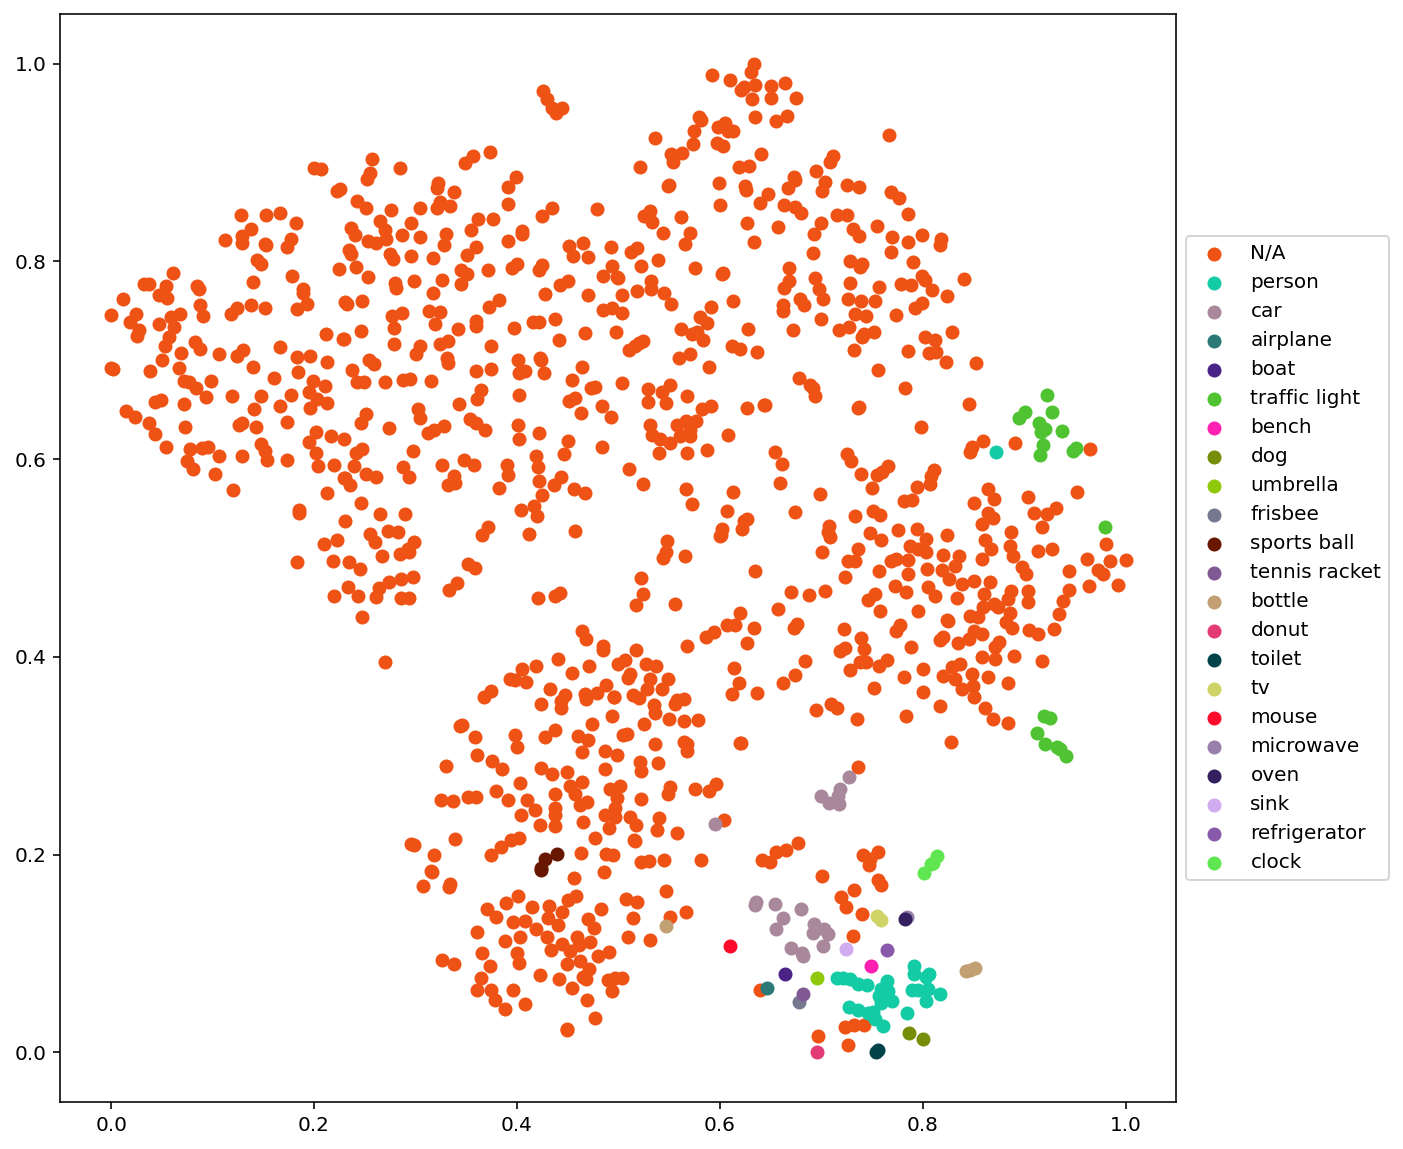

In [10]:
# initialize a matplotlib plot
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# for every class, we'll add a scatter plot separately
for label in np.unique(labels):
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]

    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)

    # add a scatter plot with the corresponding color and label
    # pass numpy array of x and y in these with color and label
    ax.scatter(current_tx, current_ty, c=np.random.rand(1,3), label=CLASSES[int(label)])

# build a legend using the labels we set previously
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# finally, show the plot
plt.show()